In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 
#list of input files

def get_mur():
    file_location = 's3://mur-sst/zarr'
    ds_sst = xr.open_zarr(fsspec.get_mapper(file_location, anon=True),consolidated=True)
    masked = ds_sst.where(((ds_sst.mask==1) or (ds_sst.sea_ice_fraction<.15)))
    masked = masked.drop({'analysis_error','mask','sea_ice_fraction'})
#    masked = ds_sst.where(((ds_sst.mask==1)))
#    masked.analysed_sst[0,2000:5000:20,18000:19000:20].plot()
#    masked = ds_sst.where(((ds_sst.mask==1) or (ds_sst.sea_ice_fraction<.15)))
#    masked.analysed_sst[0,1000:6000:200,18000:18100:10].plot()
    return masked

def get_cmc():
    file_location = 'F:/data/sat_data/sst/cmc/zarr'
    ds = xr.open_zarr(file_location)
    masked = ds.where((ds.mask<=1) & (ds.sea_ice_fraction<.15))
    sea_ice = ds.sea_ice_fraction.mean('time')
    masked = masked.drop({'analysis_error','mask','sea_ice_fraction'})
    masked['analysed_sst']-=273.15
    return masked,sea_ice

In [2]:
masked,sea_ice = get_cmc()
masked = masked.sel(time=slice('1999-01-01','2019-12-31'))
#sst_climatology = masked.groupby('time.month').mean(dim='time',keep_attrs=True,skipna=True)
sst_climatology_yr = masked.mean(dim='time',keep_attrs=True,skipna=True)
sst_std_climatology_yr = masked.std(dim='time',keep_attrs=True,skipna=True)
sst_climatology_yr

<xarray.Dataset>
Dimensions:       (lat: 901, lon: 1800)
Coordinates:
  * lat           (lat) float32 -90.0 -89.8 -89.6 -89.4 ... 89.4 89.6 89.8 90.0
  * lon           (lon) float32 -180.0 -179.8 -179.6 ... 179.4 179.6 179.8
Data variables:
    analysed_sst  (lat, lon) float32 dask.array<chunksize=(300, 300), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.4
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              Bruce.Brasnett@ec.gc.ca
    creator_name:               Bruce Brasnett, Environment Canada
    creator_url:                http://www.ec.gc.ca/scitech/default.asp?lang=...
    date_created:               20131002T175853Z
    easternmost_longitude:      179.8000030517578
    file_quality_level:         3
    gds_version_id:             02.5
    geospatial_lat_resolution:  0.20000000298023224
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.20000000298023224
    geospatial_lon_units:       degrees_east
    history:                    Processed through sfc.thin_sst, sfc.sstobs, i...
    id:                         CMC0.2deg-CMC-L4-GLOB-v2.0
    institution:                CMC
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    license:                    GHRSST protocol describes data use as free an...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    naming_authority:           org.ghrsst
    netcdf_version_id:          4.3.0
    northernmost_latitude:      90.0
    platform:                   ERS-1
    processing_level:           L4
    product_version:            2.0
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    references:                 Brasnett B. 2008. The impact of satellite ret...
    sensor:                     ATSR
    source:                     EUR-L2P-ATS_NR_2P,IN_SITU-ICOADS_BUOYS,IN_SIT...
    southernmost_latitude:      -90.0
    spatial_resolution:         0.2 degree
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    start_time:                 19910901T000000Z
    stop_time:                  19910902T000000Z
    summary:                    Applies the method of statistical interpolati...
    time_coverage_end:          19910902T000000Z
    time_coverage_start:        19910901T000000Z
    title:                      CMC 0.2 deg global sea surface temperature an...
    uuid:                       67270ff2-25d7-4390-8bc1-fee0a6209243
    westernmost_longitude:      -180.0

In [3]:
df = pd.read_excel('./../data/sst_error.xlsx')
ds = df.to_xarray().rename({'SST':'sst'})
ds = ds.swap_dims({'index':'sst'}).drop('index')
ds['std_dif']=ds.std_11GHz-ds.std_7GHz

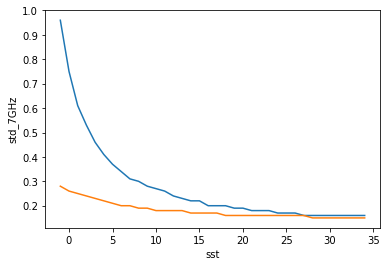

In [4]:
ds.std_11GHz.plot()
ds.std_7GHz.plot()

In [5]:
#from dask_gateway import Gateway
#from dask.distributed import Client
#gateway = Gateway()
##cluster = gateway.new_cluster()
#cluster.adapt(minimum=1, maximum=20)
#client = Client(cluster)
#cluster

In [6]:
%%time
ds_sst = sst_climatology_yr.load()

In [31]:
err_map = xr.DataArray(ds_sst.analysed_sst.data*np.NaN,coords={'lat':ds_sst.lat,'lon':ds_sst.lon},dims=('lat','lon'))
err_map = xr.Dataset({'err':err_map})
isst = (ds_sst.analysed_sst*10).astype('int')
for i in range(-30,360):
    err = ds.interp(sst=i/10,method='linear')
    err = err.std_dif.data
    tem = xr.where(isst==i,err,err_map)
    err_map['err'] = tem.err

In [ ]:
tem.err.plot()

In [ ]:
masked_yr = masked.sel(time=slice('2019-01-01','2019-12-31'))
istart=0
for i in range(len(masked_yr.time)):
    varray = masked_yr.analysed_sst[0,:,:].load()
    varray = varray.data
    vgrad = np.gradient(varray)
    mag = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
    if istart==0:
        mag2 = mag
    else:
        np.where(mag2 > mag, mag2, mag)       
masked['grad']=xr.DataArray(mag2,coords={'lat':masked.lat,'lon':masked.lon},dims=('lat','lon'))
masked.grad.to_netcdf('f:/data/project_data/fluxsat/grad.nc')

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree())
tem1 = tem.where(sea_ice<.15)
cs1 = plt.pcolormesh(tem.lon,tem.lat,tem1.err,vmin=0,vmax=.3,cmap='GnBu')
cs1 = plt.contour(tem.lon,tem.lat,masked.grad,[0,.5,1,1.5,2])
ax.coastlines()
ax.add_feature(cfeature.LAND)
cb = plt.colorbar()
cb.set_label(label='Increase in STD (K)',fontsize=16,)
plt.savefig('C:/Users/gentemann/Google Drive/f_drive/docs/proposals/nasa/EVM/7_11_err.png')

In [ ]:
#add std contour lines
sst_std_climatology_yr.load()
std_mask = sst_std_climatology_yr.where(np.isfinite(sst_climatology_yr))
plt.contour(std_mask.analysed_sst,levels=np.arange(0,2,.5))